In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pickle
import pandas as pd
import os
import json
import pyarrow as pa

In [2]:
with open('event_total.json', 'r') as f:
    event_totals = json.load(f)

In [3]:
path = '/project01/ndcms/cmoore24/skims/full_cut_skims/sole_vars/'

In [4]:
hbb = ak.from_parquet(f'{path}hbb.parquet')
hgg = ak.from_parquet(f'{path}hgg.parquet')
singletop = ak.from_parquet(f'{path}singletop.parquet')
ww = ak.from_parquet(f'{path}ww.parquet')
ww4q = ak.from_parquet(f'{path}ww4q.parquet')
zqq = ak.from_parquet(f'{path}zqq_800toInf.parquet')
wqq = ak.from_parquet(f'{path}wqq_800toInf.parquet')
ttboosted = ak.from_parquet(f'{path}ttboosted_1000toInf.parquet')

In [5]:
qcd = {}
files = os.listdir(f'{path}')
for i in files:
    if 'qcd' in i:
        qcd[i.rstrip('.parquet')] = ak.firsts(ak.from_parquet(f'{path}/{i}'))

In [6]:
vars = list(qcd['qcd_470to600'].fields)

In [7]:
IL = 44.99

In [8]:
xsec = {}
xsec['qcd_300to470'] = 6833
xsec['qcd_470to600'] = 549.5
xsec['qcd_600to800'] = 156.5
xsec['qcd_800to1000'] = 26.22
xsec['qcd_1000to1400'] = 7.475
xsec['qcd_1400to1800'] = 0.6482
xsec['qcd_1800to2400'] = 0.08742
xsec['qcd_2400to3200'] = 0.005237
xsec['qcd_3200toInf'] = 0.0001353

In [9]:
qcd_sf_dict = {}
for i in qcd:
    et_name = i.strip('qcd_')
    qcd_sf_dict[i] = (((xsec[i]*1000)*IL)/(event_totals['qcd'][f'{et_name}']))

In [10]:
def nan_remover(sample):
    if type(sample) == dict:
        for j in sample:
            mask = ak.ones_like(sample[j][sample[j].fields[0]], dtype='bool')
            mask = ak.fill_none(mask, True)
            for k in sample[j].fields:
                mask = mask & (~ak.is_none(ak.nan_to_none(sample[j][k])))
            sample[j] = sample[j][mask]
    else:
        mask = ak.ones_like(sample[sample.fields[0]], dtype='bool')
        mask = ak.fill_none(mask, True)
        for j in sample.fields:
            mask = mask & (~ak.is_none(ak.nan_to_none(sample[j])))
        sample = sample[mask]
    return sample

In [11]:
qcd = nan_remover(qcd)

In [13]:
del(qcd['qcd_300to470'])
# del(qcd['qcd_1400to1800'])
# del(qcd['qcd_1800to2400'])
# del(qcd['qcd_2400to3200'])
# del(qcd['qcd_3200toInf'])

qcd2 = qcd
# qcd2 = {}
# for i in qcd:
#     if i == 'qcd_300to470':
#         continue
#     else:
#         qcd2[i] = qcd[i]

In [14]:
qcd_stitched_dict = {}
qcd_frac = {}
for i in qcd2:
    qcd_frac[i] = ((xsec[i]*1000)*IL)/len(qcd2[i])
qcd_frac['tot'] = sum(qcd_frac.values())
sval = {}
for i in qcd2:
    sval[i] = qcd_frac[i]/qcd_frac['tot']
combed = {}
for i in qcd2:
    temp = qcd2[i]
    combed[i] = temp[np.random.rand(len(temp)) < sval[i]]
qcd_stitched_dict = ak.concatenate([combed[x] for x in combed])

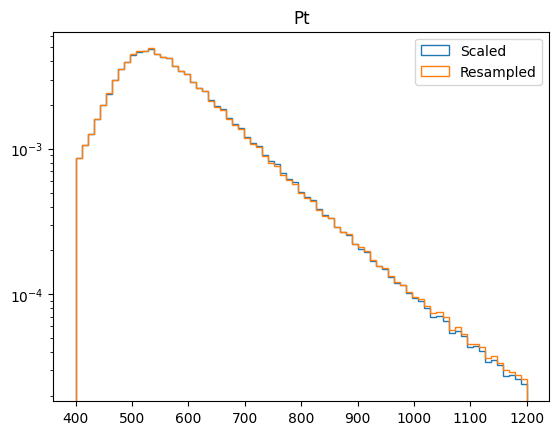

In [15]:
plt.hist(
    ak.concatenate([qcd[i].pt for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(400,1200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['pt'], range=(400,1200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

# plt.hist(
#     qcd['qcd_470to600'].pt, bins=75,
#     #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
#     range=(400,1200),
#     histtype='step',
#     density=True,
#     label='470to600'
# )
plt.yscale('log')
plt.legend()
plt.title('Pt')
plt.show()

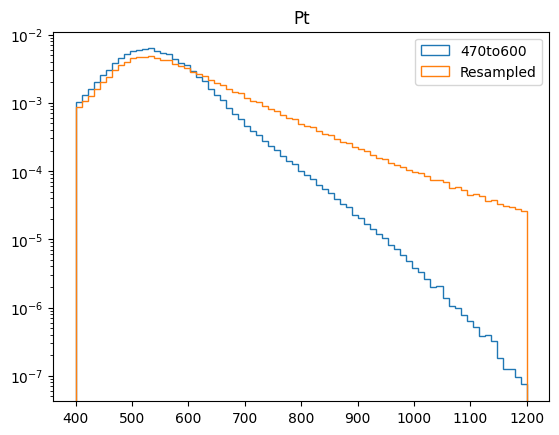

In [16]:
plt.hist(
    qcd['qcd_470to600'].pt, bins=75,
    #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(400,1200),
    histtype='step',
    density=True,
    label='470to600'
)
plt.hist(qcd_stitched_dict['pt'], range=(400,1200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
plt.yscale('log')
plt.legend()
plt.title('Pt')
plt.show()

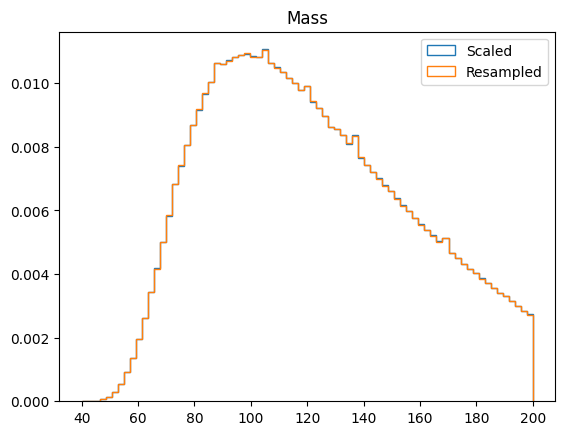

In [17]:
plt.hist(
    ak.concatenate([qcd[i].mass for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['mass'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

# plt.hist(
#     qcd['qcd_470to600'].mass, bins=75,
#     #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
#     range=(40,200),
#     histtype='step',
#     density=True,
#     label='470to600'
# )
# plt.yscale('log')
plt.legend()
plt.title('Mass')
plt.show()

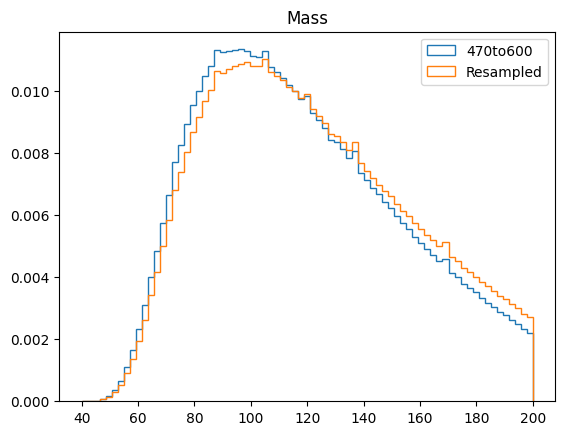

In [18]:
plt.hist(
    qcd['qcd_470to600'].mass, bins=75,
    #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='470to600'
)
plt.hist(qcd_stitched_dict['mass'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
plt.legend()
plt.title('Mass')
plt.show()

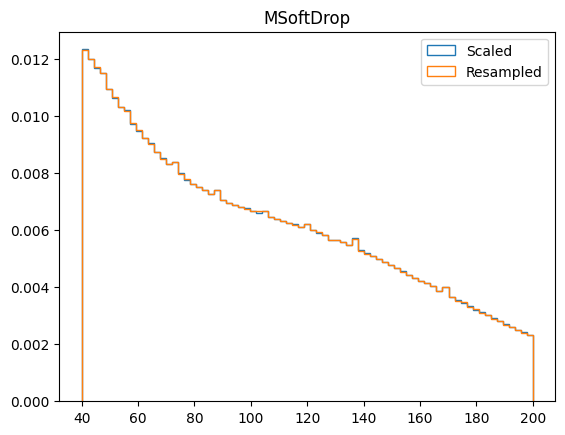

In [19]:
plt.hist(
    ak.concatenate([qcd[i].msoftdrop for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].mass) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')

# plt.hist(
#     qcd['qcd_470to600'].msoftdrop, bins=75,
#     #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
#     range=(40,200),
#     histtype='step',
#     density=True,
#     label='470to600'
# )
# plt.yscale('log')
plt.legend()
plt.title('MSoftDrop')
plt.show()

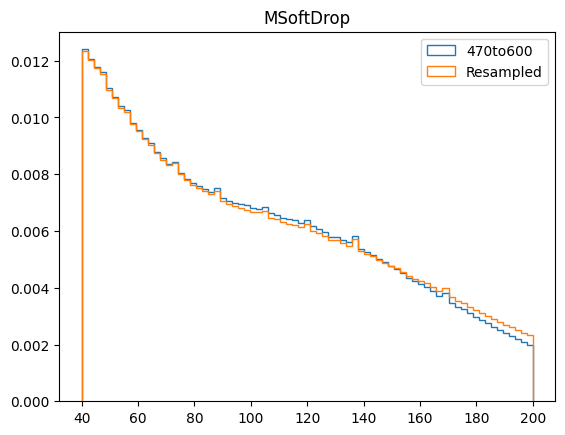

In [20]:
plt.hist(
    qcd['qcd_470to600'].msoftdrop, bins=75,
    #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(40,200),
    histtype='step',
    density=True,
    label='470to600'
)
plt.hist(qcd_stitched_dict['msoftdrop'], range=(40,200), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
plt.legend()
plt.title('MSoftDrop')
plt.show()

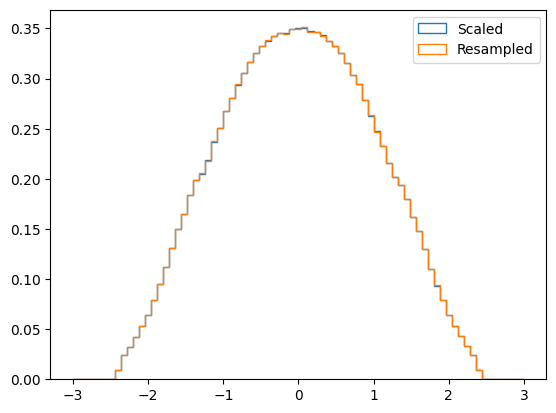

In [21]:
plt.hist(
    ak.concatenate([qcd[i].eta for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].eta) for i in qcd]),
    range=(-3,3),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['eta'], range=(-3,3), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

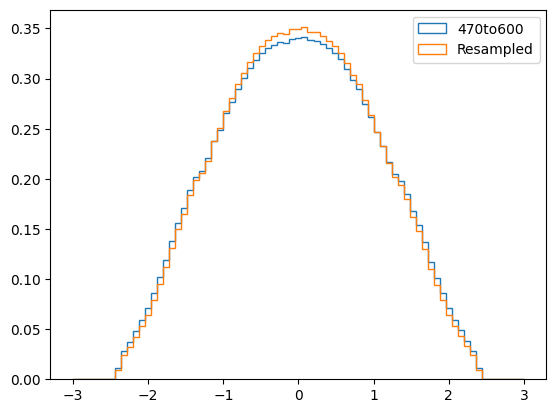

In [22]:
plt.hist(
    qcd['qcd_470to600'].eta, bins=75,
    #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(-3,3),
    histtype='step',
    density=True,
    label='470to600'
)
plt.hist(qcd_stitched_dict['eta'], range=(-3,3), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
plt.legend()
plt.show()

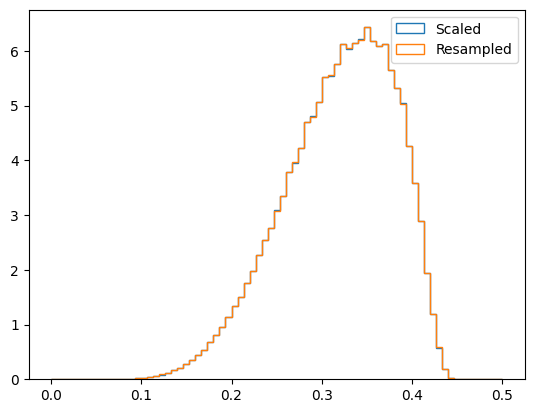

In [23]:
plt.hist(
    ak.concatenate([qcd[i].n2b1 for i in qcd]), bins=75,
    weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].n2b1) for i in qcd]),
    range=(0,0.5),
    histtype='step',
    density=True,
    label='Scaled'
)
plt.hist(qcd_stitched_dict['n2b1'], range=(0,0.5), bins=75, histtype='step', density=True, label='Resampled')
# plt.yscale('log')
plt.legend()
plt.show()

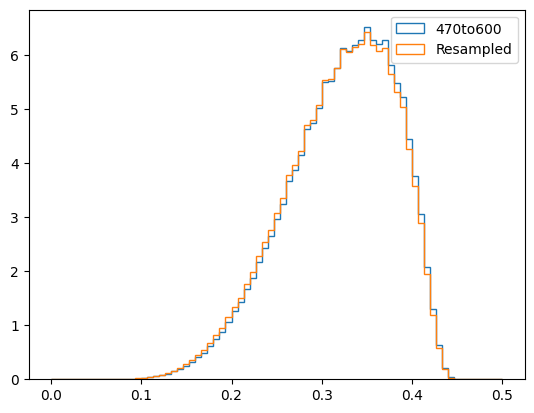

In [24]:
plt.hist(
    qcd['qcd_470to600'].n2b1, bins=75,
    #weights=ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd]),
    range=(0,.5),
    histtype='step',
    density=True,
    label='470to600'
)
plt.hist(qcd_stitched_dict['n2b1'], range=(0,.5), bins=75, histtype='step', 
         density=True, 
         label='Resampled')
plt.legend()
plt.show()

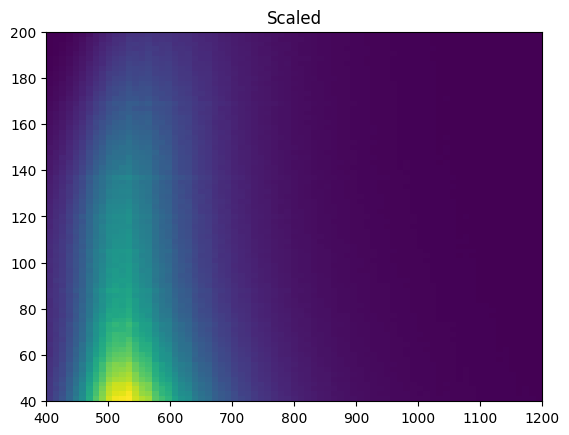

In [25]:
a = ak.concatenate([qcd[i].pt for i in qcd])
b = ak.concatenate([qcd[i].msoftdrop for i in qcd])
weights = ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd])
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), weights=weights.to_numpy(), bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.title('Scaled')
plt.show()

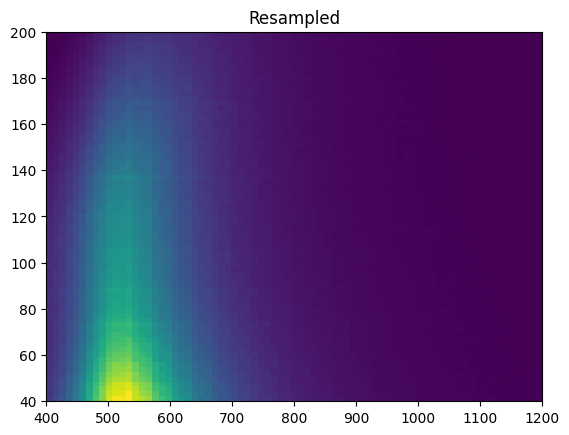

In [26]:
#cut = min(len(qcd_stitched_dict['pt']), len(qcd_stitched_dict['msoftdrop']))
e = qcd_stitched_dict.pt
f = qcd_stitched_dict.msoftdrop
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.title('Resampled')
plt.show()

In [27]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# modify existing Reds colormap with a linearly fading alpha
red = pl.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

blue = pl.cm.Blues  # original colormap
fading_blue = blue(np.arange(blue.N)) # extract colors
fading_blue[:, -1] = np.linspace(0, 1, blue.N) # modify alpha
fading_blue = ListedColormap(fading_blue) # convert to colormap

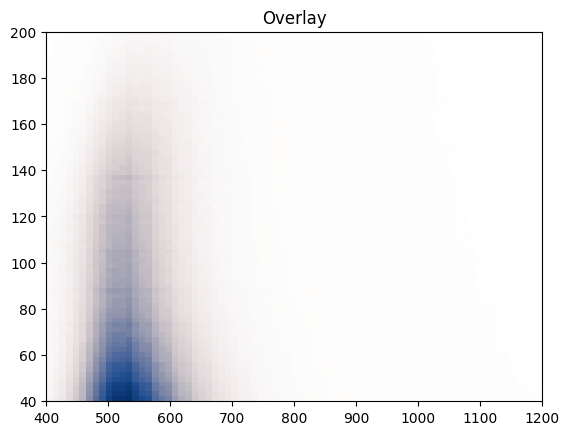

In [28]:
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[400,1200], [40,200]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True,
           range=[[400,1200], [40,200]])
plt.title('Overlay')
plt.show()

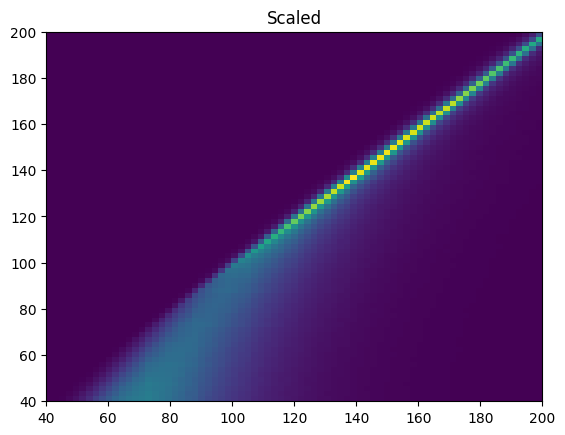

In [29]:
a = ak.concatenate([qcd[i].mass for i in qcd])
b = ak.concatenate([qcd[i].msoftdrop for i in qcd])
weights = ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd])
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), weights=weights.to_numpy(), bins=75, 
           range=[[40,200], [40,200]],
          )
plt.title('Scaled')
plt.show()

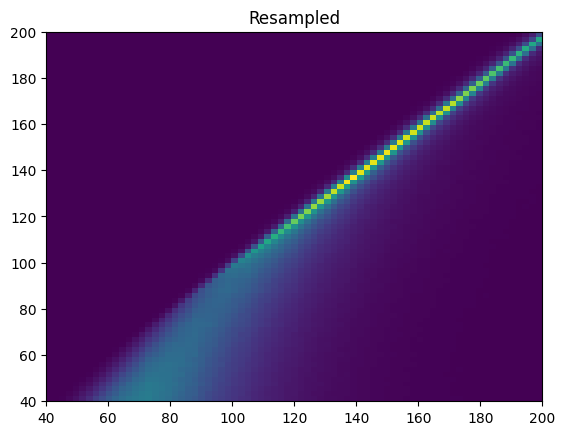

In [30]:
e = qcd_stitched_dict.mass
f = qcd_stitched_dict.msoftdrop
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, 
           range=[[40,200], [40,200]],
          )
plt.title('Resampled')
plt.show()

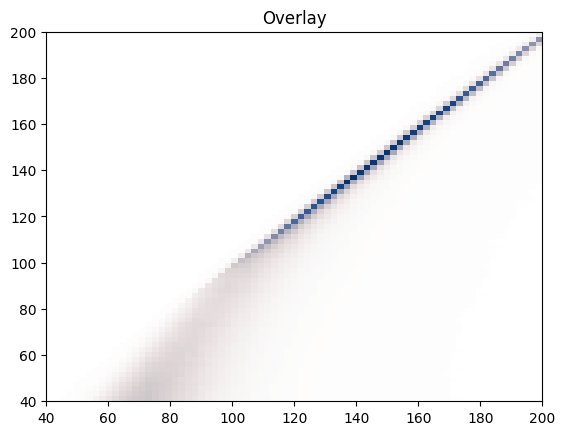

In [32]:
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[40,200], [40,200]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True,
           range=[[40,200], [40,200]])
plt.title('Overlay')
plt.show()

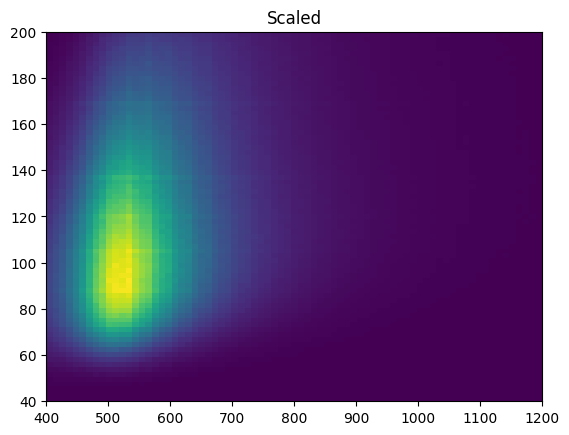

In [33]:
a = ak.concatenate([qcd[i].pt for i in qcd])
b = ak.concatenate([qcd[i].mass for i in qcd])
weights = ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd])
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), weights=weights.to_numpy(), bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.title('Scaled')
plt.show()

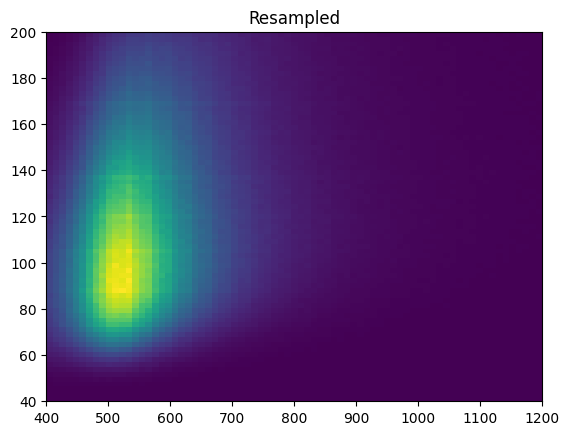

In [34]:
cut = min(len(qcd_stitched_dict['pt']), len(qcd_stitched_dict['mass']))
e = qcd_stitched_dict['pt'][:cut]
f = qcd_stitched_dict['mass'][:cut]
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.title('Resampled')
plt.show()

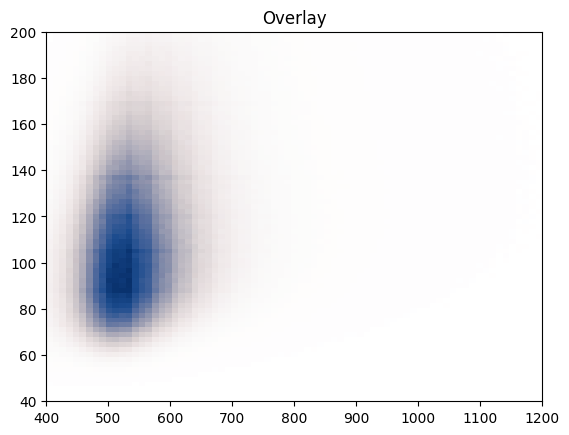

In [35]:
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[400,1200], [40,200]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True, 
           range=[[400,1200], [40,200]])
plt.title('Overlay')
plt.show()

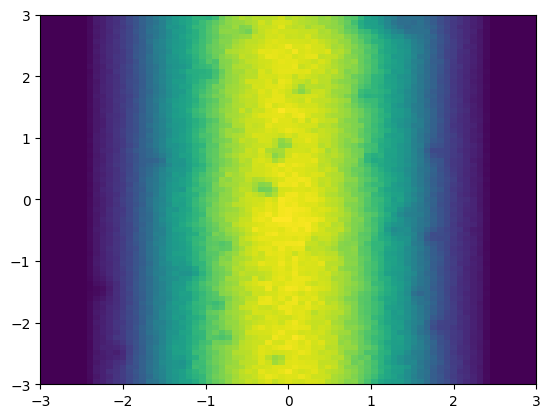

In [36]:
a = ak.concatenate([qcd[i].eta for i in qcd])
b = ak.concatenate([qcd[i].phi for i in qcd])
weights = ak.concatenate([qcd_sf_dict[i]*ak.ones_like(qcd[i].pt) for i in qcd])
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), weights=weights.to_numpy(), bins=75, 
           range=[[-3,3], [-3,3]],
          )
plt.show()

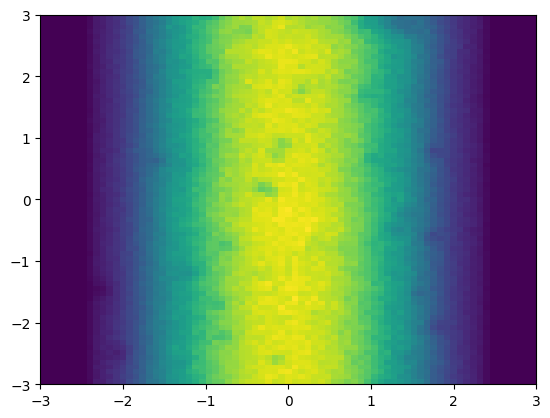

In [37]:
cut = min(len(qcd_stitched_dict['eta']), len(qcd_stitched_dict['phi']))
e = qcd_stitched_dict['eta'][:cut]
f = qcd_stitched_dict['phi'][:cut]
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, 
           range=[[-3,3], [-3,3]],
          )
plt.show()

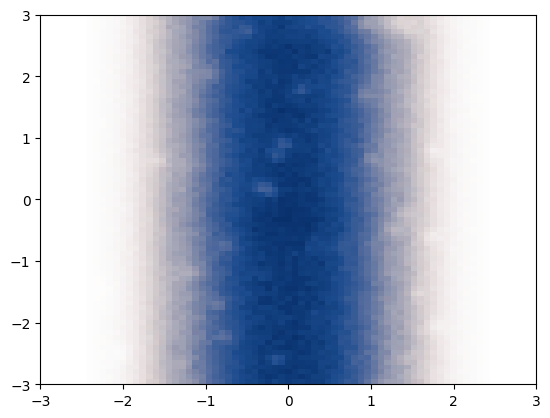

In [38]:
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[-3,3], [-3,3]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True,
           range=[[-3,3], [-3,3]])
plt.show()

In [39]:
a = qcd['qcd_300to470'].pt
b = qcd['qcd_300to470'].msoftdrop
weights = qcd_sf_dict['qcd_300to470']*ak.ones_like(qcd['qcd_300to470'].pt)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), 
           #weights=weights.to_numpy(), 
           bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.show()

KeyError: 'qcd_300to470'

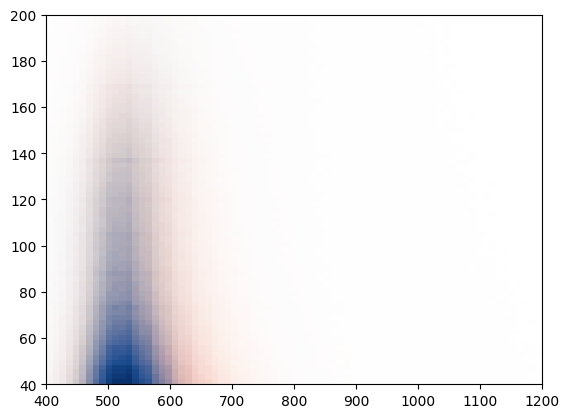

In [74]:
cut = min(len(qcd_stitched_dict['pt']), len(qcd_stitched_dict['msoftdrop']))
e = qcd_stitched_dict['pt'][:cut]
f = qcd_stitched_dict['msoftdrop'][:cut]
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[400,1200], [40,200]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True, 
           range=[[400,1200], [40,200]])
plt.show()

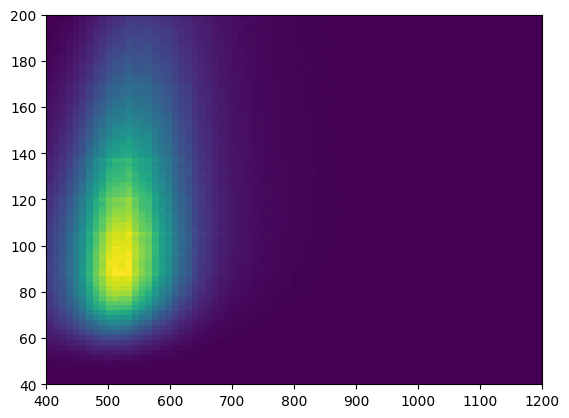

In [75]:
a = qcd['qcd_470to600'].pt
b = qcd['qcd_470to600'].mass
weights = qcd_sf_dict['qcd_470to600']*ak.ones_like(qcd['qcd_470to600'].pt)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), 
           #weights=weights.to_numpy(), 
           bins=75, 
           range=[[400,1200], [40,200]],
          )
plt.show()

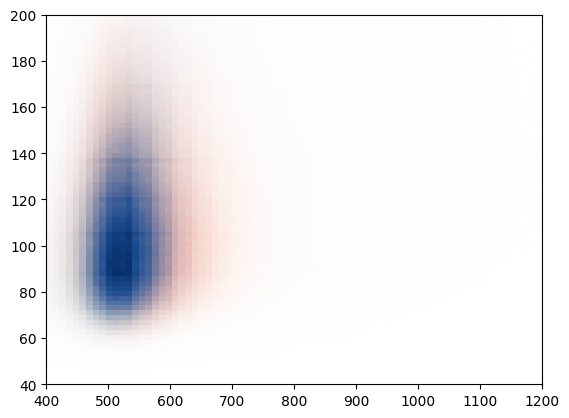

In [77]:
cut = min(len(qcd_stitched_dict['pt']), len(qcd_stitched_dict['mass']))
e = qcd_stitched_dict['pt'][:cut]
f = qcd_stitched_dict['mass'][:cut]
fig, ax = plt.subplots(1,1)
plt.hist2d(x=e.to_numpy(), y=f.to_numpy(), bins=75, range=[[400,1200], [40,200]], cmap=fading_red, density=True)
plt.hist2d(x=a.to_numpy(), y=b.to_numpy(), bins=75, weights=weights.to_numpy(), cmap=fading_blue, density=True,
           range=[[400,1200], [40,200]])
plt.show()